# Google Colab setup with Google Drive folder

This notebook provides the code you need to set up Google Colab to run and import files from within a Google Drive folder.

This will allow you to upload assignment code to your Google Drive and then run the code on Google Colab machines (with free GPUs if needed). 

You will need to create a folder in your Google Drive to hold your assignments and you will need to open Colaboratory within this folder before running the set up code (check the link above to see how).

# Mount Google Drive

This will allow the Colab machine to access Google Drive folders by mounting the drive on the machine. You will be asked to copy and paste an authentication code.

In [13]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [14]:
ls

data/  different_loss.png  weights/


# Change directory to allow imports


As noted above, you should create a Google Drive folder to hold all your assignment files. You will need to add this code to the top of any python notebook you run to be able to import python files from your drive assignment folder (you should change the file path below to be your own assignment folder). Following the hand-out, you should have a directory "SFU_CMPT_CV_lab2" on g-drive, which should have a directory "data", which contains three tar.gz files.

In [15]:
import os
os.chdir("/content/gdrive/My Drive/SFU_CMPT_CV_lab2")

In [16]:
ls # Check if this is your folder

data/  different_loss.png  weights/


# Copy data to local dir

In [17]:
!mkdir /data
!cp data/cifar100.tar.gz /data/
!tar -xf /data/cifar100.tar.gz -C /data/
!cp data/test.tar.gz /data
!tar -xf /data/test.tar.gz -C /data
!cp data/train.tar.gz /data
!tar -xf /data/train.tar.gz -C /data/

mkdir: cannot create directory ‘/data’: File exists


In [18]:
ls /data

cifar100/  cifar100.tar.gz  test/  test.tar.gz  train/  train.tar.gz


# Set up GPU and PyTorch

First, ensure that your notebook on Colaboratory is set up to use GPU. After opening the notebook on Colaboratory, go to Edit>Notebook settings, select Python 3 under "Runtime type," select GPU under "Hardware accelerator," and save.

Next, install PyTorch:

In [19]:
!pip3 install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Make sure that pytorch is installed and works with GPU:

In [20]:
import torch
a = torch.Tensor([1]).cuda()
print(a)


tensor([1.], device='cuda:0')


In [21]:
torch.cuda.is_available()

True

# Part 1

In [22]:
"""Headers"""

from __future__ import print_function
from PIL import Image
import os
import os.path
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity

import csv
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os.path
import sys
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

np.random.seed(111)
torch.cuda.manual_seed_all(111)
torch.manual_seed(111)



## **Just execute the cell below. This is the dataloader. DO NOT CHANGE ANYTHING IN HERE!**


In [23]:
""""""

class CIFAR10_SFU_CV(data.Dataset):
    """`CIFAR10 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.

    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.

    """
    base_folder = 'cifar100'
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar100.tar.gz"
    tgz_md5 = 'c58f30108f718f92721af3b95e74349a'
    train_list = [
        ['data_batch_1', 'c99cafc152244af753f735de768cd75f'],
        ['data_batch_2', 'd4bba439e000b95fd0a9bffe97cbabec'],
        ['data_batch_3', '54ebc095f3ab1f0389bbae665268c751'],
        ['data_batch_4', '634d18415352ddfa80567beed471001a'],
        ['data_batch_5', '482c414d41f54cd18b22e5b47cb7c3cb'],
    ]

    test_list = [
        ['test_batch', '40351d587109b95175f43aff81a1287e'],
    ]

    def __init__(self, root, fold="train",
                 transform=None, target_transform=None,
                 download=False):
        
        fold = fold.lower()

        self.train = False
        self.test = False
        self.val = False

        if fold == "train":
            self.train = True
        elif fold == "test":
            self.test = True
        elif fold == "val":
            self.val = True
        else:
            raise RuntimeError("Not train-val-test")


        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform

        fpath = os.path.join(root, self.filename)
        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' Download it and extract the file again.')

        # now load the picked numpy arrays
        if self.train or self.val:
            self.train_data = []
            self.train_labels = []
            for fentry in self.train_list:
                f = fentry[0]
                file = os.path.join(self.root, self.base_folder, f)
                fo = open(file, 'rb')
                if sys.version_info[0] == 2:
                    entry = pickle.load(fo)
                else:
                    entry = pickle.load(fo, encoding='latin1')
                self.train_data.append(entry['data'])
                if 'labels' in entry:
                    self.train_labels += entry['labels']
                else:
                    self.train_labels += entry['fine_labels']
                fo.close()

            self.train_data = np.concatenate(self.train_data)
            self.train_data = self.train_data.reshape((50000, 3, 32, 32))
            self.train_data = self.train_data.transpose((0, 2, 3, 1))  # convert to HWC
            
            p = np.arange(0,50000,10)
            mask_train = np.ones((50000,), dtype=bool)
            mask_train[p] = False
            mask_val = np.zeros((50000,), dtype=bool)
            mask_val[p] = True

            copy_all_data = np.array(self.train_data)
            self.val_data = np.array(copy_all_data[mask_val])
            self.train_data = np.array(copy_all_data[mask_train])
            
            copy_all_labels = np.array(self.train_labels)
            self.val_labels = np.array(copy_all_labels[mask_val])
            self.train_labels = np.array(copy_all_labels[mask_train])

        elif self.test:
            f = self.test_list[0][0]
            file = os.path.join(self.root, self.base_folder, f)
            fo = open(file, 'rb')
            if sys.version_info[0] == 2:
                entry = pickle.load(fo)
            else:
                entry = pickle.load(fo, encoding='latin1')
            self.test_data = entry['data']

            if 'labels' in entry:
                self.test_labels = entry['labels']
            else:
                self.test_labels = entry['fine_labels']
            fo.close()
            self.test_data = self.test_data.reshape((10000, 3, 32, 32))
            self.test_data = self.test_data.transpose((0, 2, 3, 1))  # convert to HWC

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        elif self.test:
            img, target = self.test_data[index], self.test_labels[index]
        elif self.val:
            img, target = self.val_data[index], self.val_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        if self.train:
            return len(self.train_data)
        elif self.test:
            return len(self.test_data)
        elif self.val:
            return len(self.val_data)

    def _check_integrity(self):
        root = self.root
        for fentry in (self.train_list + self.test_list):
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str


class CIFAR100_SFU_CV(CIFAR10_SFU_CV):
    """`CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.

    This is a subclass of the `CIFAR10` Dataset.
    """
    base_folder = 'cifar100'
    filename = "cifar100.tar.gz"
    tgz_md5 = 'e68a4c763591787a0b39fe2209371f32'
    train_list = [
        ['train_cs543', '49eee854445c1e2ebe796cd93c20bb0f'],
    ]

    test_list = [
        ['test_cs543', 'd3fe9f6a9251bd443f428f896d27384f'],
    ]

This file has been adapted from the easy-to-use tutorial released by PyTorch:
http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Training an image classifier
----------------------------

We will do the following steps in order:

1. Load the CIFAR100_SFU_CV training, validation and test datasets using
   torchvision. Use torchvision.transforms to apply transforms on the
   dataset.
2. Define a Convolution Neural Network - BaseNet
3. Define a loss function and optimizer
4. Train the network on training data and check performance on val set.
   Plot train loss and validation accuracies.
5. Try the network on test data and create .csv file for submission to kaggle

In [46]:
# <<TODO#5>> Based on the val set performance, decide how many
# epochs are apt for your model.
# ---------
EPOCHS = 400
# ---------

IS_GPU = True
TEST_BS = 128
TOTAL_CLASSES = 100
TRAIN_BS = 128
PATH_TO_CIFAR100_SFU_CV = "/data/"
# checkpoint_save_dir="./weights/"

In [25]:
ls /data/cifar100/

test_cs543  train_cs543


In [26]:
def calculate_val_accuracy(valloader, is_gpu):
    """ Util function to calculate val set accuracy,
    both overall and per class accuracy
    Args:
        valloader (torch.utils.data.DataLoader): val set 
        is_gpu (bool): whether to run on GPU
    Returns:
        tuple: (overall accuracy, class level accuracy)
    """    
    correct = 0.
    total = 0.
    predictions = []

    class_correct = list(0. for i in range(TOTAL_CLASSES))
    class_total = list(0. for i in range(TOTAL_CLASSES))

    for data in valloader:
        images, labels = data
        if is_gpu:
            images = images.cuda()
            labels = labels.cuda()
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(list(predicted.cpu().numpy()))
        total += labels.size(0)
        correct += (predicted == labels).sum()

        c = (predicted == labels).squeeze()
        c = c.cpu()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    class_accuracy = 100 * np.divide(class_correct, class_total)
    return 100*correct/total, class_accuracy

1.** Loading CIFAR100_SFU_CV**

We modify the dataset to create CIFAR100_SFU_CV dataset which consist of 45000 training images (450 of each class), 5000 validation images (50 of each class) and 10000 test images (100 of each class). The train and val datasets have labels while all the labels in the test set are set to 0.


In [27]:
# The output of torchvision datasets are PILImage images of range [0, 1].
# Using transforms.ToTensor(), transform them to Tensors of normalized range
# [-1, 1].


# <<TODO#1>> Use transforms.Normalize() with the right parameters to 
# make the data well conditioned (zero mean, std dev=1) for improved training.
# <<TODO#2>> Try using transforms.RandomCrop() and/or transforms.RandomHorizontalFlip()
# to augment training data.
# After your edits, make sure that test_transform should have the same data
# normalization parameters as train_transform
# You shouldn't have any data augmentation in test_transform (val or test data is never augmented).
# ---------------------
IMAGE_HEIGHT_WIDTH=32
train_transform = transforms.Compose(
    [transforms.RandomCrop(IMAGE_HEIGHT_WIDTH, padding=(IMAGE_HEIGHT_WIDTH // 8)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768)),])
test_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768)),])
# ---------------------

trainset = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="train",
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)
print("Train set size: "+str(len(trainset)))

valset = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="val",
                                       download=True, transform=test_transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=128,
                                         shuffle=False, num_workers=2)
print("Val set size: "+str(len(valset)))

testset = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="test",
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)
print("Test set size: "+str(len(testset)))

# The 100 classes for CIFAR100
classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']





Train set size: 45000
Val set size: 5000
Test set size: 10000


In [47]:
########################################################################
# 2. Define a Convolution Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# We provide a basic network that you should understand, run and
# eventually improve
# <<TODO>> Add more conv layers
# <<TODO>> Add more fully connected (fc) layers
# <<TODO>> Add regularization layers like Batchnorm.
#          nn.BatchNorm2d after conv layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm2d
#          nn.BatchNorm1d after fc layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm1d
# This is a good resource for developing a CNN for classification:
# http://cs231n.github.io/convolutional-networks/#layers

# import torch.nn as nn
# import torch.nn.functional as F

# import torch

# import torch.nn as nn
# import torch.optim as optim

# import torch.nn.functional as F
# from torch.autograd import Variable

# import torchvision.datasets as dset
# import torchvision.transforms as transforms
# from torch.utils.data import DataLoader

# import torchvision.models as models

# import sys
# import math



# class BaseNet(nn.Module):
#     def __init__(self):
#         super(BaseNet, self).__init__()
        
#         # <<TODO#3>> Add more conv layers with increasing 
#         # output channels
#         # <<TODO#4>> Add normalization layers after conv
#         # layers (nn.BatchNorm2d)

#         # Also experiment with kernel size in conv2d layers (say 3
#         # inspired from VGGNet)
#         # To keep it simple, keep the same kernel size
#         # (right now set to 5) in all conv layers.
#         # Do not have a maxpool layer after every conv layer in your
#         # deeper network as it leads to too much loss of information.
        
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)

#         # <<TODO#3>> Add more linear (fc) layers
#         # <<TODO#4>> Add normalization layers after linear and
#         # experiment inserting them before or after ReLU (nn.BatchNorm1d)
#         # More on nn.sequential:
#         # http://pytorch.org/docs/master/nn.html#torch.nn.Sequential
        
#         self.fc_net = nn.Sequential(
#             nn.Linear(16 * 5 * 5, TOTAL_CLASSES//2),
#             nn.ReLU(inplace=True),
#             nn.Linear(TOTAL_CLASSES//2, TOTAL_CLASSES),
#         )

#     def forward(self, x):

#         # <<TODO#3&#4>> Based on the above edits, you'll have
#         # to edit the forward pass description here.

#         x = self.pool(F.relu(self.conv1(x)))
#         # Output size = 28//2 x 28//2 = 14 x 14

#         x = self.pool(F.relu(self.conv2(x)))
#         # Output size = 10//2 x 10//2 = 5 x 5

#         # See the CS231 link to understand why this is 16*5*5!
#         # This will help you design your own deeper network
#         x = x.view(-1, 16 * 5 * 5)
#         x = self.fc_net(x)

#         # No softmax is needed as the loss function in step 3
#         # takes care of that
        
#         return x




# class EdwardNet(nn.Module):
#     def __init__(self, num_classes=100):
#         super(EdwardNet, self).__init__()
#         #32
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU())
#         #30
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU())
#         #28
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
            
        
#             )
#         #26
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2,stride=1,padding=0),
#         )
#         #25
#         self.layer5 = nn.Sequential(
#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2,stride=1,padding=0),
#             )
#         #24
#         self.layer6 = nn.Sequential(
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
        
#             )
#         #12
#         self.layer7 = nn.Sequential(
#             nn.Conv2d(256, 256, kernel_size=5, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),

        
#             )
#         #10
#         self.layer8 = nn.Sequential(
#             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2,stride=1,padding=0),
        
#             )
#         #9
#         self.layer9 = nn.Sequential(
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2,stride=1,padding=0),
        
#             )
#         #8
#         self.layer10 = nn.Sequential(
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),

        
#             )
        
#         self.layer11 = nn.Sequential(
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
            
        
#             )
#         #8
#         self.layer12 = nn.Sequential(
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2,stride=1,padding=0),
        
#             )

#         #7
#         self.fc13 = nn.Sequential(
#             # nn.Dropout(0.5),
#             nn.Linear(25088, 12544),
#             nn.ReLU())
#         self.fc14 = nn.Sequential(
#             # nn.Dropout(0.5),
#             nn.Linear(12544, 6272),
#             nn.ReLU())
#         self.fc15 = nn.Sequential(
#             # nn.Dropout(0.5),
#             nn.Linear(6272, 3136),
#             nn.ReLU())
#         self.fc16= nn.Sequential(
#             nn.Linear(3136, num_classes))
        
#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.layer5(out)
#         out = self.layer6(out)
#         out = self.layer7(out)
#         out = self.layer8(out)
#         out = self.layer9(out)
#         out = self.layer10(out)
#         out = self.layer11(out)
#         out = self.layer12(out)

#         out = out.reshape(out.size(0), -1)

#         out = self.fc13(out)
#         out = self.fc14(out)
#         out = self.fc15(out)
#         out = self.fc16(out)
#         return out



# # Create an instance of the nn.module class defined above:
# net = EdwardNet()
# #result for EdwardNet()
# '''
# [1] loss: 4.018
# Accuracy of the network on the val images: 12 %
# [2] loss: 3.473
# Accuracy of the network on the val images: 21 %
# [3] loss: 3.032
# Accuracy of the network on the val images: 29 %
# [4] loss: 2.688
# Accuracy of the network on the val images: 36 %
# [5] loss: 2.437
# Accuracy of the network on the val images: 39 %
# [6] loss: 2.243
# Accuracy of the network on the val images: 43 %
# [7] loss: 2.081
# Accuracy of the network on the val images: 46 %
# [8] loss: 1.952
# Accuracy of the network on the val images: 47 %
# [9] loss: 1.831
# Accuracy of the network on the val images: 49 %
# [10] loss: 1.723
# Accuracy of the network on the val images: 53 %
# [11] loss: 1.631
# Accuracy of the network on the val images: 51 %
# [12] loss: 1.535
# Accuracy of the network on the val images: 54 %
# [13] loss: 1.456
# Accuracy of the network on the val images: 55 %
# [14] loss: 1.378
# Accuracy of the network on the val images: 57 %
# [15] loss: 1.303
# Accuracy of the network on the val images: 58 %
# [16] loss: 1.246
# Accuracy of the network on the val images: 58 %
# [17] loss: 1.178
# Accuracy of the network on the val images: 58 %
# [18] loss: 1.105
# Accuracy of the network on the val images: 58 %
# [19] loss: 1.059
# Accuracy of the network on the val images: 60 %
# [20] loss: 0.996
# Accuracy of the network on the val images: 60 %
# [21] loss: 0.939
# Accuracy of the network on the val images: 60 %
# [22] loss: 0.888
# Accuracy of the network on the val images: 61 %
# [23] loss: 0.839
# Accuracy of the network on the val images: 62 %
# [24] loss: 0.786
# Accuracy of the network on the val images: 61 %
# [25] loss: 0.745
# Accuracy of the network on the val images: 62 %
# [26] loss: 0.708
# Accuracy of the network on the val images: 62 %
# [27] loss: 0.668
# Accuracy of the network on the val images: 62 %
# [28] loss: 0.620
# Accuracy of the network on the val images: 63 %
# [29] loss: 0.573
# Accuracy of the network on the val images: 63 %
# [30] loss: 0.542
# Accuracy of the network on the val images: 62 %
# [31] loss: 0.509
# Accuracy of the network on the val images: 62 %
# [32] loss: 0.474
# Accuracy of the network on the val images: 63 %
# [33] loss: 0.445
# Accuracy of the network on the val images: 63 %
# [34] loss: 0.417
# Accuracy of the network on the val images: 62 %
# [35] loss: 0.383
# Accuracy of the network on the val images: 63 %
# [36] loss: 0.366
# Accuracy of the network on the val images: 64 %
# [37] loss: 0.340
# Accuracy of the network on the val images: 63 %
# [38] loss: 0.328
# Accuracy of the network on the val images: 63 %
# [39] loss: 0.296
# Accuracy of the network on the val images: 63 %
# [40] loss: 0.286
# Accuracy of the network on the val images: 64 %
# [41] loss: 0.260
# Accuracy of the network on the val images: 64 %
# [42] loss: 0.245
# Accuracy of the network on the val images: 64 %
# [43] loss: 0.231
# Accuracy of the network on the val images: 64 %
# [44] loss: 0.217
# Accuracy of the network on the val images: 64 %
# [45] loss: 0.203
# Accuracy of the network on the val images: 63 %
# [46] loss: 0.197
# Accuracy of the network on the val images: 64 %
# [47] loss: 0.184
# Accuracy of the network on the val images: 63 %
# [48] loss: 0.182
# Accuracy of the network on the val images: 64 %
# [49] loss: 0.167
# Accuracy of the network on the val images: 64 %
# [50] loss: 0.158
# Accuracy of the network on the val images: 64 %
# [51] loss: 0.154
# Accuracy of the network on the val images: 64 %
# [52] loss: 0.139
# Accuracy of the network on the val images: 64 %
# [53] loss: 0.136
# Accuracy of the network on the val images: 64 %
# [54] loss: 0.131
# Accuracy of the network on the val images: 64 %
# [55] loss: 0.125
# Accuracy of the network on the val images: 64 %
# [56] loss: 0.119
# Accuracy of the network on the val images: 64 %
# [57] loss: 0.117
# Accuracy of the network on the val images: 63 %
# [58] loss: 0.113
# Accuracy of the network on the val images: 64 %
# [59] loss: 0.107
# Accuracy of the network on the val images: 63 %
# [60] loss: 0.102
# Accuracy of the network on the val images: 64 %
# [61] loss: 0.092
# Accuracy of the network on the val images: 65 %
# [62] loss: 0.090
# Accuracy of the network on the val images: 65 %
# [63] loss: 0.088
# Accuracy of the network on the val images: 64 %
# [64] loss: 0.083
# Accuracy of the network on the val images: 64 %
# [65] loss: 0.085
# Accuracy of the network on the val images: 65 %
# [66] loss: 0.075
# Accuracy of the network on the val images: 64 %
# [67] loss: 0.073
# Accuracy of the network on the val images: 64 %
# [68] loss: 0.076
# Accuracy of the network on the val images: 64 %
# [69] loss: 0.075
# Accuracy of the network on the val images: 65 %
# [70] loss: 0.074
# Accuracy of the network on the val images: 65 %
# [71] loss: 0.072
# Accuracy of the network on the val images: 65 %
# [72] loss: 0.070
# Accuracy of the network on the val images: 64 %
# [73] loss: 0.069
# Accuracy of the network on the val images: 64 %
# [74] loss: 0.060
# Accuracy of the network on the val images: 64 %
# [75] loss: 0.064
# Accuracy of the network on the val images: 65 %
# [76] loss: 0.055
# Accuracy of the network on the val images: 65 %
# [77] loss: 0.057
# Accuracy of the network on the val images: 65 %
# [78] loss: 0.055
# Accuracy of the network on the val images: 65 %
# [79] loss: 0.054
# Accuracy of the network on the val images: 65 %
# [80] loss: 0.053
# Accuracy of the network on the val images: 65 %
# [81] loss: 0.051
# Accuracy of the network on the val images: 65 %
# [82] loss: 0.053
# Accuracy of the network on the val images: 65 %
# [83] loss: 0.051
# Accuracy of the network on the val images: 65 %
# [84] loss: 0.046
# Accuracy of the network on the val images: 64 %
# [85] loss: 0.044
# Accuracy of the network on the val images: 65 %
# [86] loss: 0.037
# Accuracy of the network on the val images: 65 %
# [87] loss: 0.045
# Accuracy of the network on the val images: 65 %
# [88] loss: 0.048
# Accuracy of the network on the val images: 66 %
# [89] loss: 0.043
# Accuracy of the network on the val images: 65 %
# [90] loss: 0.041
# Accuracy of the network on the val images: 64 %
# [91] loss: 0.041
# Accuracy of the network on the val images: 65 %
# [92] loss: 0.042
# Accuracy of the network on the val images: 65 %
# [93] loss: 0.034
# Accuracy of the network on the val images: 65 %
# [94] loss: 0.044
# Accuracy of the network on the val images: 65 %
# [95] loss: 0.037
# Accuracy of the network on the val images: 65 %
# [96] loss: 0.029
# Accuracy of the network on the val images: 66 %
# [97] loss: 0.035
# Accuracy of the network on the val images: 65 %
# [98] loss: 0.032
# Accuracy of the network on the val images: 65 %
# [99] loss: 0.035
# Accuracy of the network on the val images: 64 %
# [100] loss: 0.036
# Accuracy of the network on the val images: 65 %
# Finished Training
# '''
# #seems that its would not get more using this simple architecture
# #hence, I re-implemneted dense net



# #

# '''
# class Bottleneck(nn.Module):
#     def __init__(self, nChannels, growthRate):
#         super(Bottleneck, self).__init__()
#         interChannels = 4*growthRate
#         self.bn1 = nn.BatchNorm2d(nChannels)
#         self.conv1 = nn.Conv2d(nChannels, interChannels, kernel_size=1,
#                                bias=False)
#         self.bn2 = nn.BatchNorm2d(interChannels)
#         self.conv2 = nn.Conv2d(interChannels, growthRate, kernel_size=3,
#                                padding=1, bias=False)

#     def forward(self, x):
#         out = self.conv1(F.relu(self.bn1(x)))
#         out = self.conv2(F.relu(self.bn2(out)))
#         out = torch.cat((x, out), 1)
#         return out

# class SingleLayer(nn.Module):
#     def __init__(self, nChannels, growthRate):
#         super(SingleLayer, self).__init__()
#         self.bn1 = nn.BatchNorm2d(nChannels)
#         self.conv1 = nn.Conv2d(nChannels, growthRate, kernel_size=3,
#                                padding=1, bias=False)

#     def forward(self, x):
#         out = self.conv1(F.relu(self.bn1(x)))
#         out = torch.cat((x, out), 1)
#         return out

# class Transition(nn.Module):
#     def __init__(self, nChannels, nOutChannels):
#         super(Transition, self).__init__()
#         self.bn1 = nn.BatchNorm2d(nChannels)
#         self.conv1 = nn.Conv2d(nChannels, nOutChannels, kernel_size=1,
#                                bias=False)

#     def forward(self, x):
#         out = self.conv1(F.relu(self.bn1(x)))
#         out = F.avg_pool2d(out, 2)
#         return out


# class DenseNet2(nn.Module):
#     def __init__(self, growthRate, depth, reduction, nClasses, bottleneck):
#         super(DenseNet2, self).__init__()

#         nDenseBlocks = (depth-4) // 3
#         if bottleneck:
#             nDenseBlocks //= 2

#         nChannels = 2*growthRate
#         self.conv1 = nn.Conv2d(3, nChannels, kernel_size=3, padding=1,
#                                bias=False)
#         self.dense1 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
#         nChannels += nDenseBlocks*growthRate
#         nOutChannels = int(math.floor(nChannels*reduction))
#         self.trans1 = Transition(nChannels, nOutChannels)

#         nChannels = nOutChannels
#         self.dense2 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
#         nChannels += nDenseBlocks*growthRate
#         nOutChannels = int(math.floor(nChannels*reduction))
#         self.trans2 = Transition(nChannels, nOutChannels)

#         nChannels = nOutChannels
#         self.dense3 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
#         nChannels += nDenseBlocks*growthRate

#         self.bn1 = nn.BatchNorm2d(nChannels)
#         self.fc = nn.Linear(nChannels, nClasses)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#                 m.weight.data.normal_(0, math.sqrt(2. / n))
#             elif isinstance(m, nn.BatchNorm2d):
#                 m.weight.data.fill_(1)
#                 m.bias.data.zero_()
#             elif isinstance(m, nn.Linear):
#                 m.bias.data.zero_()

#     def _make_dense(self, nChannels, growthRate, nDenseBlocks, bottleneck):
#         layers = []
#         for i in range(int(nDenseBlocks)):
#             if bottleneck:
#                 layers.append(Bottleneck(nChannels, growthRate))
#             else:
#                 layers.append(SingleLayer(nChannels, growthRate))
#             nChannels += growthRate
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = self.conv1(x)
#         out = self.trans1(self.dense1(out))
#         out = self.trans2(self.dense2(out))
#         out = self.dense3(out)
#         out = torch.squeeze(F.avg_pool2d(F.relu(self.bn1(out)), 8))
#         out = F.log_softmax(self.fc(out))
#         return out

# #first training:
# '''
# '''



# [1] loss: 4.044
# Accuracy of the network on the val images: 12 %
# [2] loss: 3.534
# Accuracy of the network on the val images: 19 %
# [3] loss: 3.117
# Accuracy of the network on the val images: 29 %
# [4] loss: 2.754
# Accuracy of the network on the val images: 34 %
# [5] loss: 2.484
# Accuracy of the network on the val images: 39 %
# [6] loss: 2.291
# Accuracy of the network on the val images: 41 %
# [7] loss: 2.125
# Accuracy of the network on the val images: 45 %
# [8] loss: 1.985
# Accuracy of the network on the val images: 47 %
# [9] loss: 1.857
# Accuracy of the network on the val images: 49 %
# [10] loss: 1.752
# Accuracy of the network on the val images: 51 %
# [11] loss: 1.653
# Accuracy of the network on the val images: 52 %
# [12] loss: 1.561
# Accuracy of the network on the val images: 55 %
# [13] loss: 1.466
# Accuracy of the network on the val images: 55 %
# [14] loss: 1.403
# Accuracy of the network on the val images: 57 %
# [15] loss: 1.321
# Accuracy of the network on the val images: 58 %
# [16] loss: 1.255
# Accuracy of the network on the val images: 58 %
# [17] loss: 1.184
# Accuracy of the network on the val images: 57 %
# [18] loss: 1.126
# Accuracy of the network on the val images: 59 %
# [19] loss: 1.058
# Accuracy of the network on the val images: 59 %
# [20] loss: 1.002
# Accuracy of the network on the val images: 61 %
# [21] loss: 0.952
# Accuracy of the network on the val images: 61 %
# [22] loss: 0.900
# Accuracy of the network on the val images: 61 %
# [23] loss: 0.846
# Accuracy of the network on the val images: 61 %
# [24] loss: 0.792
# Accuracy of the network on the val images: 61 %
# [25] loss: 0.747
# Accuracy of the network on the val images: 61 %
# [26] loss: 0.703
# Accuracy of the network on the val images: 61 %
# [27] loss: 0.662
# Accuracy of the network on the val images: 61 %
# [28] loss: 0.621
# Accuracy of the network on the val images: 61 %
# [29] loss: 0.591
# Accuracy of the network on the val images: 62 %
# [30] loss: 0.544
# Accuracy of the network on the val images: 62 %
# [31] loss: 0.511
# Accuracy of the network on the val images: 63 %
# [32] loss: 0.485
# Accuracy of the network on the val images: 63 %
# [33] loss: 0.441
# Accuracy of the network on the val images: 63 %
# [34] loss: 0.413
# Accuracy of the network on the val images: 63 %
# [35] loss: 0.387
# Accuracy of the network on the val images: 62 %
# [36] loss: 0.359
# Accuracy of the network on the val images: 63 %
# [37] loss: 0.339
# Accuracy of the network on the val images: 63 %
# [38] loss: 0.322
# Accuracy of the network on the val images: 63 %
# [39] loss: 0.298
# Accuracy of the network on the val images: 63 %
# [40] loss: 0.282
# Accuracy of the network on the val images: 64 %
# [41] loss: 0.256
# Accuracy of the network on the val images: 63 %
# [42] loss: 0.248
# Accuracy of the network on the val images: 63 %
# [43] loss: 0.228
# Accuracy of the network on the val images: 64 %
# [44] loss: 0.216
# Accuracy of the network on the val images: 63 %
# [45] loss: 0.210
# Accuracy of the network on the val images: 64 %
# [46] loss: 0.192
# Accuracy of the network on the val images: 63 %
# [47] loss: 0.185
# Accuracy of the network on the val images: 64 %
# [48] loss: 0.180
# Accuracy of the network on the val images: 64 %
# [49] loss: 0.165
# Accuracy of the network on the val images: 64 %
# [50] loss: 0.161
# Accuracy of the network on the val images: 64 %
# [51] loss: 0.155
# Accuracy of the network on the val images: 64 %
# [52] loss: 0.145
# Accuracy of the network on the val images: 64 %
# [53] loss: 0.139
# Accuracy of the network on the val images: 64 %
# [54] loss: 0.124
# Accuracy of the network on the val images: 65 %
# [55] loss: 0.117
# Accuracy of the network on the val images: 64 %
# [56] loss: 0.120
# Accuracy of the network on the val images: 65 %
# [57] loss: 0.112
# Accuracy of the network on the val images: 65 %
# [58] loss: 0.109
# Accuracy of the network on the val images: 65 %
# [59] loss: 0.105
# Accuracy of the network on the val images: 64 %
# [60] loss: 0.098
# Accuracy of the network on the val images: 65 %
# [61] loss: 0.094
# Accuracy of the network on the val images: 65 %
# [62] loss: 0.089
# Accuracy of the network on the val images: 65 %
# [63] loss: 0.097
# Accuracy of the network on the val images: 63 %
# [64] loss: 0.086
# Accuracy of the network on the val images: 64 %
# [65] loss: 0.084
# Accuracy of the network on the val images: 64 %
# [66] loss: 0.082
# Accuracy of the network on the val images: 65 %
# [67] loss: 0.080
# Accuracy of the network on the val images: 65 %
# [68] loss: 0.071
# Accuracy of the network on the val images: 65 %
# [69] loss: 0.070
# Accuracy of the network on the val images: 64 %
# [70] loss: 0.069
# Accuracy of the network on the val images: 65 %
# [71] loss: 0.067
# Accuracy of the network on the val images: 65 %
# [72] loss: 0.066
# Accuracy of the network on the val images: 65 %
# [73] loss: 0.061
# Accuracy of the network on the val images: 65 %
# [74] loss: 0.061
# Accuracy of the network on the val images: 66 %
# [75] loss: 0.055
# Accuracy of the network on the val images: 65 %
# [76] loss: 0.058
# Accuracy of the network on the val images: 64 %
# [77] loss: 0.054
# Accuracy of the network on the val images: 64 %
# [78] loss: 0.055
# Accuracy of the network on the val images: 65 %
# [79] loss: 0.054
# Accuracy of the network on the val images: 65 %
# [80] loss: 0.051
# Accuracy of the network on the val images: 65 %
# [81] loss: 0.053
# Accuracy of the network on the val images: 64 %
# [82] loss: 0.044
# Accuracy of the network on the val images: 65 %
# [83] loss: 0.049
# Accuracy of the network on the val images: 65 %
# [84] loss: 0.044
# Accuracy of the network on the val images: 65 %
# [85] loss: 0.044
# Accuracy of the network on the val images: 65 %
# [86] loss: 0.045
# Accuracy of the network on the val images: 64 %
# [87] loss: 0.049
# Accuracy of the network on the val images: 65 %
# [88] loss: 0.042
# Accuracy of the network on the val images: 65 %
# [89] loss: 0.041
# Accuracy of the network on the val images: 65 %
# [90] loss: 0.039
# Accuracy of the network on the val images: 65 %
# [91] loss: 0.029
# Accuracy of the network on the val images: 65 %
# [92] loss: 0.034
# Accuracy of the network on the val images: 66 %
# [93] loss: 0.034
# Accuracy of the network on the val images: 65 %
# [94] loss: 0.040
# Accuracy of the network on the val images: 65 %
# [95] loss: 0.036
# Accuracy of the network on the val images: 65 %
# [96] loss: 0.036
# Accuracy of the network on the val images: 66 %
# [97] loss: 0.035
# Accuracy of the network on the val images: 65 %
# [98] loss: 0.039
# Accuracy of the network on the val images: 65 %
# [99] loss: 0.038
# Accuracy of the network on the val images: 65 %
# [100] loss: 0.035
# Accuracy of the network on the val images: 65 %
# [101] loss: 0.031
# Accuracy of the network on the val images: 66 %
# [102] loss: 0.030
# Accuracy of the network on the val images: 65 %
# [103] loss: 0.030
# Accuracy of the network on the val images: 66 %
# [104] loss: 0.029
# Accuracy of the network on the val images: 66 %
# [105] loss: 0.034
# Accuracy of the network on the val images: 65 %
# [106] loss: 0.038
# Accuracy of the network on the val images: 65 %
# [107] loss: 0.027
# Accuracy of the network on the val images: 66 %
# [108] loss: 0.029
# Accuracy of the network on the val images: 66 %
# [109] loss: 0.026
# Accuracy of the network on the val images: 65 %
# [110] loss: 0.028
# Accuracy of the network on the val images: 65 %
# [111] loss: 0.032
# Accuracy of the network on the val images: 66 %
# [112] loss: 0.023
# Accuracy of the network on the val images: 65 %
# [113] loss: 0.026
# Accuracy of the network on the val images: 66 %
# [114] loss: 0.026
# Accuracy of the network on the val images: 65 %
# [115] loss: 0.023
# Accuracy of the network on the val images: 66 %
# [116] loss: 0.024
# Accuracy of the network on the val images: 65 %
# [117] loss: 0.025
# Accuracy of the network on the val images: 66 %
# [118] loss: 0.023
# Accuracy of the network on the val images: 66 %
# [119] loss: 0.020
# Accuracy of the network on the val images: 65 %
# [120] loss: 0.021
# Accuracy of the network on the val images: 66 %
# Finished Training

# '''





import torch

import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
from torch.autograd import Variable

import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import torchvision.models as models

import sys
import math

class Bottleneck(nn.Module):
    def __init__(self, nChannels, growthRate):
        super(Bottleneck, self).__init__()
        interChannels = 4*growthRate
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, interChannels, kernel_size=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(interChannels)
        self.conv2 = nn.Conv2d(interChannels, growthRate, kernel_size=3,
                               padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat((x, out), 1)
        return out

class SingleLayer(nn.Module):
    def __init__(self, nChannels, growthRate):
        super(SingleLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, growthRate, kernel_size=3,
                               padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = torch.cat((x, out), 1)
        return out

class Transition(nn.Module):
    def __init__(self, nChannels, nOutChannels):
        super(Transition, self).__init__()
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, nOutChannels, kernel_size=1,
                               bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, growthRate, depth, reduction, nClasses, bottleneck):
        super(DenseNet, self).__init__()

        nDenseBlocks = (depth-4) // 3
        if bottleneck:
            nDenseBlocks //= 2

        nChannels = 2*growthRate
        self.conv1 = nn.Conv2d(3, nChannels, kernel_size=3, padding=1,
                               bias=False)
        self.dense1 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate
        nOutChannels = int(math.floor(nChannels*reduction))
        self.trans1 = Transition(nChannels, nOutChannels)

        nChannels = nOutChannels
        self.dense2 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate
        nOutChannels = int(math.floor(nChannels*reduction))
        self.trans2 = Transition(nChannels, nOutChannels)

        nChannels = nOutChannels
        self.dense3 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate

        self.bn1 = nn.BatchNorm2d(nChannels)
        self.fc = nn.Linear(nChannels, nClasses)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def _make_dense(self, nChannels, growthRate, nDenseBlocks, bottleneck):
        layers = []
        for i in range(int(nDenseBlocks)):
            if bottleneck:
                layers.append(Bottleneck(nChannels, growthRate))
            else:
                layers.append(SingleLayer(nChannels, growthRate))
            nChannels += growthRate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.dense3(out)
        out = torch.squeeze(F.avg_pool2d(F.relu(self.bn1(out)), 8))
        out = F.log_softmax(self.fc(out))
        return out






import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

class simplenet(nn.Module):
    def __init__(self, classes=100, simpnet_name='simplenet'):
        super(simplenet, self).__init__()
        #print(simpnet_name)
        self.features = self._make_layers() #self._make_layers(cfg[simpnet_name])
        self.classifier = nn.Linear(256, classes)
        self.drp = nn.Dropout(0.1)

    def load_my_state_dict(self, state_dict):

        own_state = self.state_dict()

        # print(own_state.keys())
        # for name, val in own_state:
        # print(name)
        for name, param in state_dict.items():
            name = name.replace('module.', '')
            if name not in own_state:
                # print(name)
                continue
            if isinstance(param, Parameter):
                # backwards compatibility for serialized parameters
                param = param.data
            print("STATE_DICT: {}".format(name))
            try:
                own_state[name].copy_(param)
            except:
                print('While copying the parameter named {}, whose dimensions in the model are'
                      ' {} and whose dimensions in the checkpoint are {}, ... Using Initial Params'.format(
                    name, own_state[name].size(), param.size()))

    def forward(self, x):
        out = self.features(x)

        #Global Max Pooling
        out = F.max_pool2d(out, kernel_size=out.size()[2:]) 
        # out = F.dropout2d(out, 0.1, training=True)
        out = self.drp(out)

        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self):

        model = nn.Sequential(
                             nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),

                             nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),

                             nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),

                             nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),


                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
                             nn.Dropout2d(p=0.1),


                             nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),

                             nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),

                             nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),



                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
                             nn.Dropout2d(p=0.1),


                             nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),


                             nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),



                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
                             nn.Dropout2d(p=0.1),



                             nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(512, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),



                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
                             nn.Dropout2d(p=0.1),


                             nn.Conv2d(512, 2048, kernel_size=[1, 1], stride=(1, 1), padding=(0, 0)),
                             nn.BatchNorm2d(2048, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),



                             nn.Conv2d(2048, 256, kernel_size=[1, 1], stride=(1, 1), padding=(0, 0)),
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),


                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
                             nn.Dropout2d(p=0.1),


                             nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),

                            )

        for m in model.modules():
          if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))

        return model





# def resnet(**kwargs):
#     """
#     Constructs a ResNet model.
#     """
#     return ResNet(**kwargs)





# device = args.device # "cuda" / "cpu"
# if "cuda" in device and not torch.cuda.is_available():
#     device = "cpu"
# data = data.to(device)
# model.to(device)
def main():
    # device = args.device # "cuda" / "cpu"
    # if "cuda" in device and not torch.cuda.is_available():
    #   device = "cpu"

    a=torch.rand(32,3,32,32)
    a=a.cuda()
    # net=EdwardNet()
    # net =DenseNet(growthRate=12, depth=100, reduction=0.5,
    #                         bottleneck=True, nClasses=100)
    # net=simplenet()
    net=DenseNet(growthRate=12, depth=120, reduction=0.5,
                            bottleneck=True, nClasses=100)
    if IS_GPU:
        net=net.cuda()

    outputs = net(a)
    print(a.shape)
    print(outputs.shape)


if __name__ == '__main__':
    main()

torch.Size([32, 3, 32, 32])
torch.Size([32, 100])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:908: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [48]:
########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Here we use Cross-Entropy loss and SGD with momentum.
# The CrossEntropyLoss criterion already includes softmax within its
# implementation. That's why we don't use a softmax in our model
# definition.

import torch.optim as optim


net=simplenet()
if IS_GPU:
    net=net.cuda()
# criterion = nn.CrossEntropyLoss()
# net =DenseNet(growthRate=12, depth=100, reduction=0.5,
#                             bottleneck=True, nClasses=100)

optimizer = optim.SGD(net.parameters(), lr=0.06,momentum=0.9, weight_decay=5e-4)
# optimizer = torch.optim.Adadelta(net.parameters(), lr=0.1, rho=0.9, eps=1e-3, # momentum=state['momentum'],
#                                      weight_decay=0.001)
plt.ioff()
fig = plt.figure()
train_loss_over_epochs = []
val_accuracy_over_epochs = []

In [49]:

def adjust_opt(optAlg, optimizer, epoch):
    if optAlg == 'sgd':
        if epoch < 150: lr = 1e-1
        elif epoch == 150: lr = 1e-2
        elif epoch == 225: lr = 1e-3
        else: return

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

In [35]:
#this block is just for recording anther try of using different model

#well, the simple net converge at 65%, so this is useless

#***************ignore this block

# '''

# '''

# checkpoint_save_dir='/weights/'

# CHECKPOINT_SAVE_EPOCH_INTERVAL=30
# if (not os.path.exists(checkpoint_save_dir)):
#         os.makedirs(checkpoint_save_dir)
#         print(f"Created checkpoint save dir `{checkpoint_save_dir}`.")
# elif (os.path.isdir(checkpoint_save_dir)):
#         print(f"Using existing checkpoint save dir `{checkpoint_save_dir}`.")
#         existing_filenames = os.listdir(checkpoint_save_dir)
#         if existing_filenames:
#             print(f"Existing checkpoint files in this directory will be overwritten.")
# else:
#         raise FileExistsError(f"Checkpoint save dir `{checkpoint_save_dir}` is not a folder.")   
# ########################################################################
# # 4. Train the network
# # ^^^^^^^^^^^^^^^^^^^^
# #
# # We simply have to loop over our data iterator, and feed the inputs to the
# # network and optimize. We evaluate the validation accuracy at each
# # epoch and plot these values over the number of epochs
# # Nothing to change here
# # -----------------------------
# train_loss_visual=[]
# valid_loss_visual=[]


# VAL_EPOCH_INTERVAL=1

# # for epoch in range(EPOCHS):  # loop over the dataset multiple times

# #     running_loss = 0.0
# #     for i, data in enumerate(trainloader, 0):
# #         # get the inputs
# #         inputs, labels = data

# #         if IS_GPU:
# #             inputs = inputs.cuda()
# #             labels = labels.cuda()

# #         # wrap them in Variable
# #         inputs, labels = Variable(inputs), Variable(labels)

# #         # zero the parameter gradients
# #         optimizer.zero_grad()

# #         # forward + backward + optimize
# #         outputs = net(inputs)
# #         loss = criterion(outputs, labels)
# #         loss.backward()
# #         optimizer.step()

# #         # print statistics
# #         running_loss += loss.item()
    
# #     # Normalizing the loss by the total number of train batches
# #     running_loss/=len(trainloader)
# #     print('[%d] loss: %.3f' %
# #           (epoch + 1, running_loss))

# #     # Scale of 0.0 to 100.0
# #     # Calculate validation set accuracy of the existing model
# #     val_accuracy, val_classwise_accuracy = 
# #         calculate_val_accuracy(valloader, IS_GPU)
# #     print('Accuracy of the network on the val images: %d %%' % (val_accuracy))

# #     # # Optionally print classwise accuracies
# #     # for c_i in range(TOTAL_CLASSES):
# #     #     print('Accuracy of %5s : %2d %%' % (
# #     #         classes[c_i], 100 * val_classwise_accuracy[c_i]))

# #     train_loss_over_epochs.append(running_loss)
# #     val_accuracy_over_epochs.append(val_accuracy)
# # # -----------------------------
# #     # MARK: Save checkpoint
# #     if ((epoch % CHECKPOINT_SAVE_EPOCH_INTERVAL) == 0):
# #         checkpoint_filename = os.path.join(checkpoint_save_dir, f"{epoch}.pth")
# #         torch.save(net.state_dict(), checkpoint_filename)
# #         print(f"Checkpoint saved as `{checkpoint_filename}`")


# trainloss=[]
# validloss=[]

# criterion = nn.CrossEntropyLoss()
# for epoch in range(EPOCHS):  # loop over the dataset multiple times
#         net.train()
#         # running_loss = 0.0
#         running_loss = 0.0
#         train_loss=0.
#         train_count=0
#         train_correct_count = 0
#         for image, label in trainloader:

#             if IS_GPU:
#                 image = image.cuda()
#                 label = label.cuda()
#             image, label = Variable(image), Variable(label)
#             # zero the parameter gradients
#             optimizer.zero_grad()
#             # forward + backward + optimize
#             net=net.cuda()

#             outputs = net(image)
       
#             loss = criterion(outputs, label)

#             loss.backward()
#             optimizer.step()

#             # print statistics
#         #     running_loss += loss.item()
#         # running_loss/=len(trainloader)
#         # print('[%d] loss: %.3f' %
#         # (epoch + 1, running_loss))
#         # train_loss_visual.append(running_loss)

#             train_loss += loss.item()
#             train_count += image.shape[0]

#             _, max_prediction_indices = torch.max(outputs, -1)
#             train_correct_count += torch.sum(max_prediction_indices == label).item()

#         print(f"Epoch {epoch}: accuracy: {train_correct_count / train_count}, total loss: {train_loss}, average loss: {train_loss / train_count}")
#         train_loss_visual.append(train_loss)
#         trainloss.append(train_loss)
        
#         # Normalizing the loss by the total number of train batches
#         # running_loss/=len(trainloader)
#         # print('[%d] loss: %.3f' %
#         #     (epoch + 1, running_loss))

#         # Scale of 0.0 to 100.0
#         # Calculate validation set accuracy of the existing model
#         # val_accuracy, val_classwise_accuracy = \
#         #     calculate_val_accuracy(valloader, IS_GPU)
#         # print('Accuracy of the network on the val images: %d %%' % (val_accuracy))

#         # # Optionally print classwise accuracies
#         # for c_i in range(TOTAL_CLASSES):
#         #     print('Accuracy of %5s : %2d %%' % (
#         #         classes[c_i], 100 * val_classwise_accuracy[c_i]))
#         if (epoch % VAL_EPOCH_INTERVAL == 0):
           
#             net.eval()
#             validation_loss = 0.
#             validation_count = 0
#             validation_correct_count = 0
#             with torch.no_grad():    # [Very important] Reduce memory usage.
#                 for image, label in valloader :
#                     image = image.cuda()
#                     label = label.cuda()

#                     prediction = net(image)
#                     loss = criterion(prediction, label)
#                     validation_loss += loss.item()
#                     validation_count += image.shape[0]

#                     _, max_prediction_indices = torch.max(prediction, -1)
#                     validation_correct_count += torch.sum(max_prediction_indices == label).item()

       
#             print(f"Validation: accuracy: {validation_correct_count / validation_count}, total loss: {validation_loss}, average loss: {validation_loss / validation_count}")
#             valid_loss_visual.append(validation_loss)
#             validloss.append(validation_loss)
#               # Calculate validation set accuracy of the existing model
#             # temp=calculate_val_accuracy(valloader, IS_GPU)
#             # val_accuracy, val_classwise_accuracy = temp
#             # print('Accuracy of the network on the val images: %d %%' % (val_accuracy))

#     # # # Optionally print classwise accuracies
#     #     train_loss_over_epochs.append(running_loss)
#     #     val_accuracy_over_epochs.append(val_accuracy)


#     # -----------------------------
#         # MARK: Save checkpoint
#         if ((epoch % CHECKPOINT_SAVE_EPOCH_INTERVAL) == 0):
        
#             checkpoint_filename = os.path.join(checkpoint_save_dir, f"{epoch}.pth")
#             torch.save(net.state_dict(), checkpoint_filename)
#             print(f"Checkpoint saved as `{checkpoint_filename}`")

        

# trainlossnp=np.array(trainloss)
# validlossnp=np.array(validloss)
# plt.plot(trainlossnp)
# plt.plot(validlossnp)
# plt.show()
# plt.savefig('different_loss.png')


# # Plot train loss over epochs and val set accuracy over epochs
# # Nothing to change here
# # -------------
# # plt.subplot(2, 1, 1)
# # plt.ylabel('Train loss')
# # plt.plot(np.arange(EPOCHS), train_loss_over_epochs, 'k-')
# # plt.title('train loss and val accuracy')
# # plt.xticks(np.arange(EPOCHS, dtype=int))
# # plt.grid(True)

# # plt.subplot(2, 1, 2)
# # val_accuracy_over_epochs = torch.tensor(val_accuracy_over_epochs, device = 'cpu')
# # plt.plot(np.arange(EPOCHS), val_accuracy_over_epochs, 'b-')
# # plt.ylabel('Val accuracy')
# # plt.xlabel('Epochs')
# # plt.xticks(np.arange(EPOCHS, dtype=int))
# # plt.grid(True)
# # plt.savefig("plot.png")
# # plt.close(fig)
# # print('Finished Training')
# # -------------


Created checkpoint save dir `/weights/`.
Epoch 0: accuracy: 0.08186666666666667, total loss: 1420.4041509628296, average loss: 0.03156453668806288
Validation: accuracy: 0.1186, total loss: 148.92884588241577, average loss: 0.029785769176483155
Checkpoint saved as `/weights/0.pth`
Epoch 1: accuracy: 0.15344444444444444, total loss: 1245.875774383545, average loss: 0.02768612831963433
Validation: accuracy: 0.1866, total loss: 135.34211897850037, average loss: 0.027068423795700073
Epoch 2: accuracy: 0.20537777777777777, total loss: 1142.3123931884766, average loss: 0.025384719848632813
Validation: accuracy: 0.2516, total loss: 118.55835604667664, average loss: 0.023711671209335327
Epoch 3: accuracy: 0.2510222222222222, total loss: 1053.6407656669617, average loss: 0.023414239237043593
Validation: accuracy: 0.2772, total loss: 113.32902264595032, average loss: 0.022665804529190064
Epoch 4: accuracy: 0.29131111111111113, total loss: 974.4333233833313, average loss: 0.02165407385296292
Valid

KeyboardInterrupt: ignored

Using existing checkpoint save dir `/weights/`.
Existing checkpoint files in this directory will be overwritten.
Epoch 0: accuracy: 0.08273333333333334, total loss: 1407.1718492507935, average loss: 0.031270485538906524
Validation: accuracy: 0.1334, total loss: 145.76429343223572, average loss: 0.029152858686447142
Checkpoint saved as `/weights/0.pth`
Epoch 1: accuracy: 0.16173333333333334, total loss: 1222.250857591629, average loss: 0.027161130168702866
Validation: accuracy: 0.189, total loss: 131.47013092041016, average loss: 0.026294026184082032
Epoch 2: accuracy: 0.22791111111111112, total loss: 1088.2772047519684, average loss: 0.024183937883377075
Validation: accuracy: 0.2768, total loss: 114.87057399749756, average loss: 0.022974114799499512
Epoch 3: accuracy: 0.2844888888888889, total loss: 976.1606216430664, average loss: 0.02169245825873481
Validation: accuracy: 0.3222, total loss: 104.00015068054199, average loss: 0.0208000301361084
Epoch 4: accuracy: 0.33795555555555556, t

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

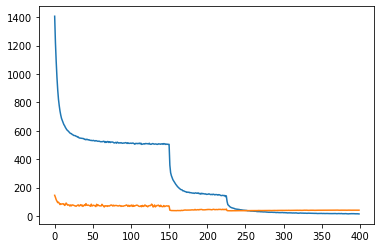

In [50]:

checkpoint_save_dir='/weights/'

CHECKPOINT_SAVE_EPOCH_INTERVAL=40
if (not os.path.exists(checkpoint_save_dir)):
        os.makedirs(checkpoint_save_dir)
        print(f"Created checkpoint save dir `{checkpoint_save_dir}`.")
elif (os.path.isdir(checkpoint_save_dir)):
        print(f"Using existing checkpoint save dir `{checkpoint_save_dir}`.")
        existing_filenames = os.listdir(checkpoint_save_dir)
        if existing_filenames:
            print(f"Existing checkpoint files in this directory will be overwritten.")
else:
        raise FileExistsError(f"Checkpoint save dir `{checkpoint_save_dir}` is not a folder.")   
########################################################################
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^^
#
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize. We evaluate the validation accuracy at each
# epoch and plot these values over the number of epochs
# Nothing to change here
# -----------------------------
train_loss_visual=[]
valid_loss_visual=[]


VAL_EPOCH_INTERVAL=1

# for epoch in range(EPOCHS):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs
#         inputs, labels = data

#         if IS_GPU:
#             inputs = inputs.cuda()
#             labels = labels.cuda()

#         # wrap them in Variable
#         inputs, labels = Variable(inputs), Variable(labels)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
    
#     # Normalizing the loss by the total number of train batches
#     running_loss/=len(trainloader)
#     print('[%d] loss: %.3f' %
#           (epoch + 1, running_loss))

#     # Scale of 0.0 to 100.0
#     # Calculate validation set accuracy of the existing model
#     val_accuracy, val_classwise_accuracy = 
#         calculate_val_accuracy(valloader, IS_GPU)
#     print('Accuracy of the network on the val images: %d %%' % (val_accuracy))

#     # # Optionally print classwise accuracies
#     # for c_i in range(TOTAL_CLASSES):
#     #     print('Accuracy of %5s : %2d %%' % (
#     #         classes[c_i], 100 * val_classwise_accuracy[c_i]))

#     train_loss_over_epochs.append(running_loss)
#     val_accuracy_over_epochs.append(val_accuracy)
# # -----------------------------
#     # MARK: Save checkpoint
#     if ((epoch % CHECKPOINT_SAVE_EPOCH_INTERVAL) == 0):
#         checkpoint_filename = os.path.join(checkpoint_save_dir, f"{epoch}.pth")
#         torch.save(net.state_dict(), checkpoint_filename)
#         print(f"Checkpoint saved as `{checkpoint_filename}`")

loss_function = nn.CrossEntropyLoss()
trainloss=[]
validloss=[]


for epoch in range(EPOCHS):  # loop over the dataset multiple times
        net.train()
        # running_loss = 0.0
        running_loss = 0.0
        train_loss=0.
        train_count=0
        train_correct_count = 0
        for image, label in trainloader:

            if IS_GPU:
                image = image.cuda()
                label = label.cuda()
            image, label = Variable(image), Variable(label)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            net=net.cuda()

            outputs = net(image)
       
            # loss = F.nll_loss(outputs, label)
            loss = loss_function(outputs, label)
            loss.backward()
            optimizer.step()

            # print statistics
        #     running_loss += loss.item()
        # running_loss/=len(trainloader)
        # print('[%d] loss: %.3f' %
        # (epoch + 1, running_loss))
        # train_loss_visual.append(running_loss)

            train_loss += loss.item()
            train_count += image.shape[0]

            _, max_prediction_indices = torch.max(outputs, -1)
            train_correct_count += torch.sum(max_prediction_indices == label).item()

        print(f"Epoch {epoch}: accuracy: {train_correct_count / train_count}, total loss: {train_loss}, average loss: {train_loss / train_count}")
        train_loss_visual.append(train_loss)
        trainloss.append(train_loss)
        
        # Normalizing the loss by the total number of train batches
        # running_loss/=len(trainloader)
        # print('[%d] loss: %.3f' %
        #     (epoch + 1, running_loss))

        # Scale of 0.0 to 100.0
        # Calculate validation set accuracy of the existing model
        # val_accuracy, val_classwise_accuracy = \
        #     calculate_val_accuracy(valloader, IS_GPU)
        # print('Accuracy of the network on the val images: %d %%' % (val_accuracy))

        # # Optionally print classwise accuracies
        # for c_i in range(TOTAL_CLASSES):
        #     print('Accuracy of %5s : %2d %%' % (
        #         classes[c_i], 100 * val_classwise_accuracy[c_i]))
        if (epoch % VAL_EPOCH_INTERVAL == 0):
           
            net.eval()
            validation_loss = 0.
            validation_count = 0
            validation_correct_count = 0
            with torch.no_grad():    # [Very important] Reduce memory usage.
                for image, label in valloader :
                    image = image.cuda()
                    label = label.cuda()

                    prediction = net(image)
                    # loss = F.nll_loss(prediction, label)
                    
                    loss = loss_function(prediction, label)
                    validation_loss += loss.item()
                    validation_count += image.shape[0]

                    _, max_prediction_indices = torch.max(prediction, -1)
                    validation_correct_count += torch.sum(max_prediction_indices == label).item()

       
            print(f"Validation: accuracy: {validation_correct_count / validation_count}, total loss: {validation_loss}, average loss: {validation_loss / validation_count}")
            valid_loss_visual.append(validation_loss)
            validloss.append(validation_loss)
              # Calculate validation set accuracy of the existing model
            # temp=calculate_val_accuracy(valloader, IS_GPU)
            # val_accuracy, val_classwise_accuracy = temp
            # print('Accuracy of the network on the val images: %d %%' % (val_accuracy))

    # # # Optionally print classwise accuracies
    #     train_loss_over_epochs.append(running_loss)
    #     val_accuracy_over_epochs.append(val_accuracy)


    # -----------------------------
        # MARK: Save checkpoint
        if ((epoch % CHECKPOINT_SAVE_EPOCH_INTERVAL) == 0):
        
            checkpoint_filename = os.path.join(checkpoint_save_dir, f"{epoch}.pth")
            torch.save(net.state_dict(), checkpoint_filename)
            print(f"Checkpoint saved as `{checkpoint_filename}`")

        adjust_opt('sgd',optimizer, epoch)

trainlossnp=np.array(trainloss)
validlossnp=np.array(validloss)
plt.plot(trainlossnp)
plt.plot(validlossnp)
plt.show()
plt.savefig('different_loss.png')


# Plot train loss over epochs and val set accuracy over epochs
# Nothing to change here
# -------------
# plt.subplot(2, 1, 1)
# plt.ylabel('Train loss')
# plt.plot(np.arange(EPOCHS), train_loss_over_epochs, 'k-')
# plt.title('train loss and val accuracy')
# plt.xticks(np.arange(EPOCHS, dtype=int))
# plt.grid(True)

# plt.subplot(2, 1, 2)
# val_accuracy_over_epochs = torch.tensor(val_accuracy_over_epochs, device = 'cpu')
# plt.plot(np.arange(EPOCHS), val_accuracy_over_epochs, 'b-')
# plt.ylabel('Val accuracy')
# plt.xlabel('Epochs')
# plt.xticks(np.arange(EPOCHS, dtype=int))
# plt.grid(True)
# plt.savefig("plot.png")
# plt.close(fig)
# print('Finished Training')
# -------------



In [52]:
########################################################################
# 5. Try the network on test data, and create .csv file
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
########################################################################
#0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010
test_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768)),])


testset = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="test",
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)
print("Test set size: "+str(len(testset)))

# Check out why .eval() is important!
# https://discuss.pytorch.org/t/model-train-and-model-eval-vs-model-and-model-eval/5744/2

checkpoint_file='./weight/280.pth'
net.load_state_dict(torch.load(checkpoint_filename))
net.eval()

total = 0
predictions = []
for data in testloader:
    images, labels = data

    # For training on GPU, we need to transfer net and data onto the GPU
    # http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
    if IS_GPU:
        images = images.cuda()
        labels = labels.cuda()
    
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend(list(predicted.cpu().numpy()))
    total += labels.size(0)

with open('submission_netid.csv', 'w') as csvfile:
    wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
    wr.writerow(["Id", "Prediction1"])
    for l_i, label in enumerate(predictions):
        wr.writerow([str(l_i), str(label)])

Test set size: 10000


# Part 2

In [53]:
"""Headers"""
import os
import os.path as osp
import time

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

from torchvision import datasets

# Pre-Trained Model

TODO1. Load pretrained resnet model. Experiment with different models. 

TODO2: Replace last fc layer

TODO3. Forward pass

In [54]:
class PreTrainedResNet(nn.Module):
  def __init__(self, num_classes, feature_extracting):
    super(PreTrainedResNet, self).__init__()
    
    #TODO1: Load pre-trained ResNet Model
    self.resnet18 = models.resnet18(pretrained=True)

    #Set gradients to false
    if feature_extracting:
      for param in self.resnet18.parameters():
          param.requires_grad = False
    
    #Replace last fc layer
    num_feats = self.resnet18.fc.in_features
    self.resnet18.fc = nn.Linear(num_feats, num_classes)
    #TODO2: Replace fc layer in resnet to a linear layer of size (num_feats, num_classes)
    
  def forward(self, x):
    #TODO3: Forward pass x through the model
    x = self.resnet18(x)
    return x

  # def set_train_last_only(self, new_val: bool):
  #     for param in self.resnet18.parameters():
  #         if new_val:
  #             param.requires_grad = False
  #         else:
  #             param.requires_grad = True


# Train

In [55]:
def train(model, optimizer, criterion, epoch, num_epochs):
  model.train()
  epoch_loss = 0.0
  epoch_acc = 0.0
  
  for batch_idx, (images, labels) in enumerate(dataloaders['train']):
    #zero the parameter gradients
    optimizer.zero_grad()
    
    #move to GPU
    images, labels = images.cuda(), labels.cuda()
    
    #forward
    outputs = model.forward(images)
    
    loss = criterion(outputs, labels)
    
    _, preds = torch.max(outputs.data, 1)
    
    loss.backward()
    optimizer.step()
    
    epoch_loss += loss.item()
    epoch_acc += torch.sum(preds == labels).item()
    
  epoch_loss /= dataset_sizes['train']
  epoch_acc /= dataset_sizes['train']
  
  print('TRAINING Epoch %d/%d Loss %.4f Accuracy %.4f' % (epoch, num_epochs, epoch_loss, epoch_acc))

# Main

1. Vary hyperparams
2. Data augmentation

In [56]:
#TODO: Vary Hyperparams

NUM_EPOCHS = 80
LEARNING_RATE = 0.0004 
BATCH_SIZE = 32
RESNET_LAST_ONLY = False #Fine tunes only the last layer. Set to False to fine tune entire network

root_path = '/data/' #If your data is in a different folder, set the path accodordingly

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        # transforms.CenterCrop(224),

        #TODO: Transforms.RandomResizedCrop() instead of CenterCrop(), RandomRoate() and Horizontal Flip()
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(4/5, 6/5)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #TODO: Transforms.Normalize()
        transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #TODO: Transforms.Normalize()
        transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    ]),
}

# loading datasets with PyTorch ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(root_path, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

#Initialize the model
model = PreTrainedResNet(len(class_names), RESNET_LAST_ONLY)
model = model.cuda()

#Setting the optimizer and loss criterion
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
criterion = nn.CrossEntropyLoss()

#Begin Train
for epoch in range(NUM_EPOCHS):
  train(model, optimizer, criterion, epoch+1, NUM_EPOCHS)
  
print("Finished Training")
print("-"*10)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

TRAINING Epoch 1/80 Loss 0.1687 Accuracy 0.0077
TRAINING Epoch 2/80 Loss 0.1593 Accuracy 0.0303
TRAINING Epoch 3/80 Loss 0.1512 Accuracy 0.0967
TRAINING Epoch 4/80 Loss 0.1429 Accuracy 0.1743
TRAINING Epoch 5/80 Loss 0.1352 Accuracy 0.2507
TRAINING Epoch 6/80 Loss 0.1276 Accuracy 0.3333
TRAINING Epoch 7/80 Loss 0.1202 Accuracy 0.4057
TRAINING Epoch 8/80 Loss 0.1129 Accuracy 0.4697
TRAINING Epoch 9/80 Loss 0.1063 Accuracy 0.5163
TRAINING Epoch 10/80 Loss 0.1003 Accuracy 0.5600
TRAINING Epoch 11/80 Loss 0.0943 Accuracy 0.5980
TRAINING Epoch 12/80 Loss 0.0889 Accuracy 0.6370
TRAINING Epoch 13/80 Loss 0.0840 Accuracy 0.6667
TRAINING Epoch 14/80 Loss 0.0793 Accuracy 0.6940
TRAINING Epoch 15/80 Loss 0.0749 Accuracy 0.7257
TRAINING Epoch 16/80 Loss 0.0707 Accuracy 0.7433
TRAINING Epoch 17/80 Loss 0.0673 Accuracy 0.7573
TRAINING Epoch 18/80 Loss 0.0634 Accuracy 0.7770
TRAINING Epoch 19/80 Loss 0.0600 Accuracy 0.8030
TRAINING Epoch 20/80 Loss 0.0571 Accuracy 0.8167
TRAINING Epoch 21/80 Loss 0.0

# Test

In [57]:
def test(model, criterion, repeats=2):
  model.eval()
  
  test_loss = 0.0
  test_acc = 0.0
  
  with torch.no_grad():
    for itr in range(repeats):
      for batch_idx, (images, labels) in enumerate(dataloaders['test']):
        #move to GPU
        images, labels = images.cuda(), labels.cuda()

        #forward
        outputs = model.forward(images)

        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)

        test_loss += loss.item()
        test_acc += torch.sum(preds == labels).item()

    test_loss /= (dataset_sizes['test']*repeats)
    test_acc /= (dataset_sizes['test']*repeats)

    print('Test Loss: %.4f Test Accuracy %.4f' % (test_loss, test_acc))


In [58]:
test(model, criterion)

Test Loss: 0.0535 Test Accuracy 0.5846


# Visualizing the model predictions

Only for viusalizing. Nothing to be done here. 

In [59]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(1)  # pause a bit so that plots are updated
    
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()

    for batch_idx, (images, labels) in enumerate(dataloaders['test']):
        #move to GPU
        images, labels = images.cuda(), labels.cuda()
        
        outputs = model(images)
        
        _, preds = torch.max(outputs.data, 1)
       

        for j in range(images.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))

            imshow(images.cpu().data[j])

            if images_so_far == num_images:
                return

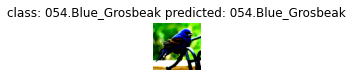

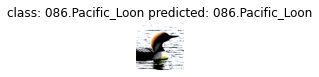

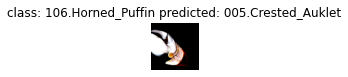

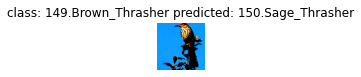

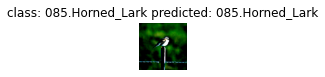

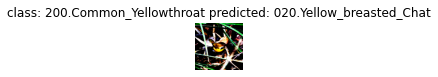

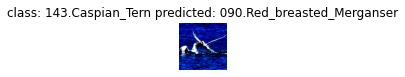

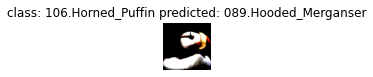

In [60]:
visualize_model(model)